# Intro: "Zachary’s karate club" Problem

In [3]:
import dgl
import numpy as np

- Build the graph

In [4]:
""" 
In DGL, one array stores Source points, one array stores destination points. 
There's NO seperate array just for points. 
 """
def build_karate_club_graph():
	# All 78 edges are stored in two numpy arrays. 
    # One for source endpoints
	# while the other for destination endpoints.
	src = np.array([1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 10, 10,
		10, 11, 12, 12, 13, 13, 13, 13, 16, 16, 17, 17, 19, 19, 21, 21,
		25, 25, 27, 27, 27, 28, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32,
		32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
		33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
	dst = np.array([0, 0, 1, 0, 1, 2, 0, 0, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2, 0, 4,
		5, 0, 0, 3, 0, 1, 2, 3, 5, 6, 0, 1, 0, 1, 0, 1, 23, 24, 2, 23,
		24, 2, 23, 26, 1, 8, 0, 24, 25, 28, 2, 8, 14, 15, 18, 20, 22, 23,
		29, 30, 31, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30,
		31, 32])
	# Edges are directional in DGL; Make them bi-directional.
	u = np.concatenate([src, dst])
	v = np.concatenate([dst, src])
	# Construct a DGLGraph
	return dgl.graph((u, v))

In [5]:
G = build_karate_club_graph()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 34 nodes.
We have 156 edges.


- Visualization

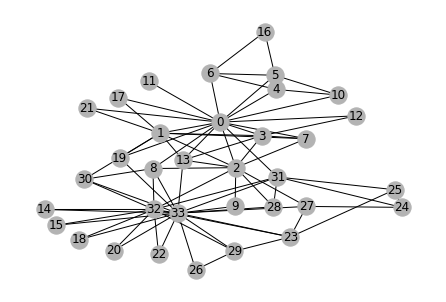

In [6]:
import networkx as nx
%matplotlib inline
# Since the actual graph is undirected, we convert it for visualization purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

- Add Features

In [7]:
""" In DGL, you can add features for all nodes at once, using a feature tensor that
batches node features along the first dimension. The code below adds the learnable
embeddings for all nodes: """

import torch
import torch.nn as nn
import torch.nn.functional as F

""" initiate the feature embedding
34 nodes with embedding dim equal to 5 """
embed = nn.Embedding(34, 5)  

""" ndata for nodes, edata for edges 
can have multiple feature embeddings, so it's a dictionary """
G.ndata['feat'] = embed.weight

# print out shape of node feature 'feat' 
print(G.ndata['feat'].shape)

# print out node 2's input feature
print(G.ndata['feat'][2])

# print out node 10 and 11's input features
print(G.ndata['feat'][[10, 11]])

torch.Size([34, 5])
tensor([ 1.2327, -1.0510, -0.3478, -0.9585,  2.7185],
       grad_fn=<SelectBackward0>)
tensor([[-1.2406,  1.0151, -0.8661,  0.3347,  1.9859],
        [-0.5146, -0.7244, -0.7533,  1.0869,  0.3447]],
       grad_fn=<IndexBackward0>)


- Message Passing

In [8]:
from dgl.nn.pytorch import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        """ first layer: input features (size=5) => hidden layer (size=5) """
        self.conv1 = GraphConv(in_feats, hidden_size)
        """ second layer: hidden layer (size=5) => output features (size=2) """
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h
# The first layer transforms input features of size of 5 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(5, 5, 2)

- Preprocessing and Initialization

In [9]:
inputs = embed.weight
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

- Model Training

In [10]:
import itertools

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(50):
	logits = net(G, inputs)
	# we save the logits for visualization later
	all_logits.append(logits.detach())
	logp = F.log_softmax(logits, 1)
	# we only compute loss for labeled nodes
	loss = F.nll_loss(logp[labeled_nodes], labels)

	optimizer.zero_grad()
	loss.backward()
	optimizer.step()

	print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.8509
Epoch 1 | Loss: 0.8217
Epoch 2 | Loss: 0.7958
Epoch 3 | Loss: 0.7730
Epoch 4 | Loss: 0.7530
Epoch 5 | Loss: 0.7366
Epoch 6 | Loss: 0.7223
Epoch 7 | Loss: 0.7092
Epoch 8 | Loss: 0.6964
Epoch 9 | Loss: 0.6844
Epoch 10 | Loss: 0.6723
Epoch 11 | Loss: 0.6605
Epoch 12 | Loss: 0.6486
Epoch 13 | Loss: 0.6374
Epoch 14 | Loss: 0.6258
Epoch 15 | Loss: 0.6140
Epoch 16 | Loss: 0.6020
Epoch 17 | Loss: 0.5899
Epoch 18 | Loss: 0.5781
Epoch 19 | Loss: 0.5663
Epoch 20 | Loss: 0.5546
Epoch 21 | Loss: 0.5431
Epoch 22 | Loss: 0.5317
Epoch 23 | Loss: 0.5206
Epoch 24 | Loss: 0.5096
Epoch 25 | Loss: 0.4986
Epoch 26 | Loss: 0.4875
Epoch 27 | Loss: 0.4765
Epoch 28 | Loss: 0.4654
Epoch 29 | Loss: 0.4541
Epoch 30 | Loss: 0.4425
Epoch 31 | Loss: 0.4306
Epoch 32 | Loss: 0.4182
Epoch 33 | Loss: 0.4055
Epoch 34 | Loss: 0.3923
Epoch 35 | Loss: 0.3791
Epoch 36 | Loss: 0.3659
Epoch 37 | Loss: 0.3525
Epoch 38 | Loss: 0.3388
Epoch 39 | Loss: 0.3257
Epoch 40 | Loss: 0.3126
Epoch 41 | Loss: 0.2997
Ep

/Users/riliu/opt/anaconda3/lib/python3.8/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


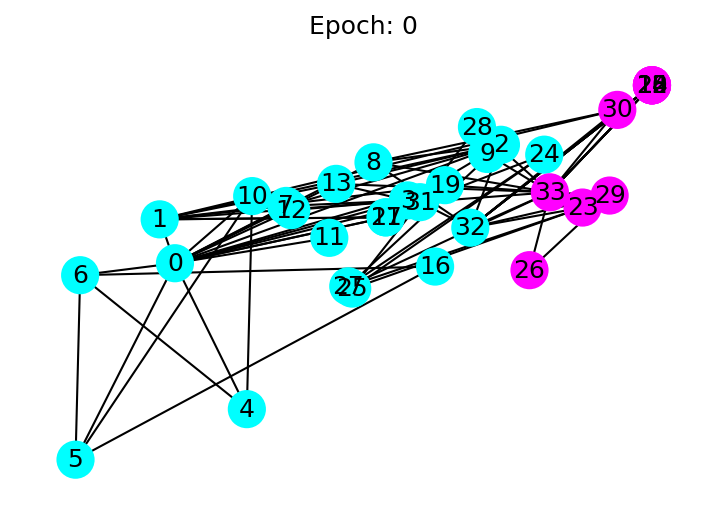

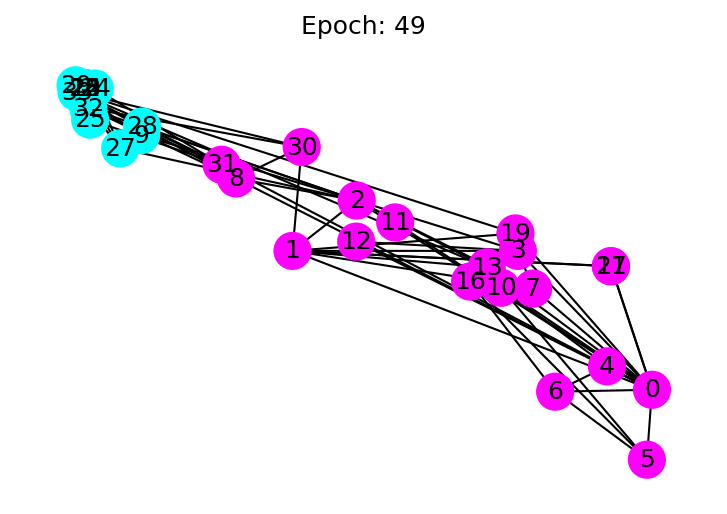

In [18]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(i):
	cls1color = '#00FFFF'
	cls2color = '#FF00FF'
	pos = {}
	colors = []
	for v in range(34):
		pos[v] = all_logits[i][v].numpy()
		cls = pos[v].argmax()
		colors.append(cls1color if cls else cls2color)
	ax.cla()
	ax.axis('off')
	ax.set_title('Epoch: %d' % i)
	nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
			with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch
# plt.close()
fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(49)  # draw the prediction of the first epoch

# 1 Graph

Graph: 
- Homogeneous: each nodes are the same items, as well as each edges 
- Heterogeneous

- Creat a Graph

In [32]:
import dgl
import torch as th
# edges 0->1, 0->2, 0->3, 1->3
u, v = th.tensor([0, 0, 0, 1]), th.tensor([1, 2, 3, 3])
g = dgl.graph((u, v))
print(g) # number of nodes are inferred from the max node IDs in the given edges
# get Node IDs, currently there're only 4 nodes (as they have edges)
print(g.nodes())
# get Edge end nodes
print(g.edges())
# get Edge end nodes and edge IDs
print(g.edges(form='all'))
# If the node with the largest ID is isolated (meaning no edges),
# then one needs to explicitly set the number of nodes
# Now we have 8 nodes, some of them do not have edges
g = dgl.graph((u, v), num_nodes=8)

Graph(num_nodes=4, num_edges=4,
      ndata_schemes={}
      edata_schemes={})
tensor([0, 1, 2, 3])
(tensor([0, 0, 0, 1]), tensor([1, 2, 3, 3]))
(tensor([0, 0, 0, 1]), tensor([1, 2, 3, 3]), tensor([0, 1, 2, 3]))


In [35]:
""" convert the directed graph to undirected graph (bi-directed) """
bd = dgl.to_bidirected(g)
bd.edges()

(tensor([0, 0, 0, 1, 1, 2, 3, 3]), tensor([1, 2, 3, 0, 3, 0, 0, 1]))

In [42]:
""" data type conversion """
print(bd.idtype)
bd_64 = bd.long()
print(bd_64.idtype)
bd_32 = bd.int()
print(bd_32.idtype)

torch.int64
torch.int64
torch.int32


- Add features to Nodes and Edges

In [43]:
""" the first dimension of a feature must has the same size as the size of nodes or edges """
import dgl
import torch as th
g = dgl.graph(([0, 0, 1, 5], [1, 2, 2, 0])) # 6 nodes, 4 edges
print(g)
g.ndata['x'] = th.ones(g.num_nodes(), 3)               # node feature of length 3
g.edata['x'] = th.ones(g.num_edges(), dtype=th.int32)  # scalar integer feature
print(g)
# different names can have different shapes
g.ndata['y'] = th.randn(g.num_nodes(), 5)
print(g.ndata['x'][1])                  # get node 1's feature
print(g.edata['x'][th.tensor([0, 3])])  # get features of edge 0 and 3

Graph(num_nodes=6, num_edges=4,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=6, num_edges=4,
      ndata_schemes={'x': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'x': Scheme(shape=(), dtype=torch.int32)})
tensor([1., 1., 1.])
tensor([1, 1], dtype=torch.int32)


- Heterogenous Graph

In [50]:
import dgl
import torch as th
# Create a heterograph with 3 node types and 3 edges types.
graph_data = {
    # 'source node', 'relationship edge', 'objective node' 
   ('drug', 'interacts', 'drug'): (th.tensor([0, 1]), th.tensor([1, 2])),
   ('drug', 'interacts', 'gene'): (th.tensor([0, 1]), th.tensor([2, 3])),
   ('drug', 'treats', 'disease'): (th.tensor([1]), th.tensor([2]))
}
g = dgl.heterograph(graph_data)
print('node types:', g.ntypes)
print('edge types:', g.etypes)
print('edge relationship types:', g.canonical_etypes)
print('Graph: ', g)
print('Edges: ', g.metagraph().edges())
print('size of nodes: ', g.num_nodes())
print('size of a type of nodes: ', g.num_nodes('drug'))
print('node ids in a type: ', g.nodes('drug'))

node types: ['disease', 'drug', 'gene']
edge types: ['interacts', 'interacts', 'treats']
edge relationship types: [('drug', 'interacts', 'drug'), ('drug', 'interacts', 'gene'), ('drug', 'treats', 'disease')]
Graph:  Graph(num_nodes={'disease': 3, 'drug': 3, 'gene': 4},
      num_edges={('drug', 'interacts', 'drug'): 2, ('drug', 'interacts', 'gene'): 2, ('drug', 'treats', 'disease'): 1},
      metagraph=[('drug', 'drug', 'interacts'), ('drug', 'gene', 'interacts'), ('drug', 'disease', 'treats')])
Edges:  [('drug', 'drug'), ('drug', 'gene'), ('drug', 'disease')]
size of nodes:  10
size of a type of nodes:  3
node ids in a type:  tensor([0, 1, 2])


In [51]:
""" features of heterogeneous graphs """
# Set/get feature 'hv' for nodes of type 'drug'
g.nodes['drug'].data['hv'] = th.ones(3, 1)
print(g.nodes['drug'].data['hv'])
# Set/get feature 'he' for edge of type 'treats'
g.edges['treats'].data['he'] = th.zeros(1, 1)
print(g.edges['treats'].data['he'])

tensor([[1.],
        [1.],
        [1.]])
tensor([[0.]])


# 2 Message Passing

## Built-in message passing functions

The naming convention for message built-in funcs is that `u` represents src nodes, `v` represents dst nodes, and `e` represents edges.

In [55]:
""" 
Message Function: 
arg: edges
'hu' + 'hv' -> 'he'
add the hu feature from src nodes and hv feature from dst nodes then save the result on the edge at he field
 """
def message_func(edges):
     return {'he': edges.src['hu'] + edges.dst['hv']}

In [56]:
""" 
Reduce Function:
arg: nodes 
sums up the message m
 """
def reduce_func(nodes):
     return {'h': torch.sum(nodes.mailbox['m'], dim=1)}

In [58]:
""" 
Update Function: 
message generation -> message aggregation -> node update
'ft' * 'a' -> 'm' 
-> sum('m')
-> update 'ft'
 """
def update_all_example(graph):
    # store the result in graph.ndata['ft']
    graph.update_all(fn.u_mul_e('ft', 'a', 'm'),
                        fn.sum('m', 'ft'))
    # Call update function outside of update_all
    final_ft = graph.ndata['ft'] * 2
    return final_ft

In [63]:
""" When there's no message passing, but just calculate on edge-wise """
import dgl.function as fn
# g.apply_edges(fn.u_add_v('el', 'er', 'e'))	

## High efficiency message passing 

In [ ]:
import torch
import torch.nn as nn

linear = nn.Parameter(torch.FloatTensor(size=(node_feat_dim * 2, out_dim)))
def concat_message_function(edges):
     return {'cat_feat': torch.cat([edges.src['feat'], edges.dst['feat']], dim=1)}
g.apply_edges(concat_message_function)
g.edata['out'] = g.edata['cat_feat'] @ linear

# 3 Building GNN Modules - SAGEConv as an Example 

In [4]:
import torch.nn as nn

import dgl.function as fn
import torch.nn.functional as F
from dgl.utils import check_eq_shape

from dgl.utils import expand_as_pair
""" 
specifies the graph type and expand feat into 'feat_src' and 'feat_dst', 
For homogeneous whole graph training, source nodes and destination nodes are the same. 
They are all the nodes in the graph. 
"""
# def expand_as_pair(input_, g=None):
#     if isinstance(input_, tuple):
#         # Bipartite graph case
#         return input_
#     elif g is not None and g.is_block:
#         # Subgraph block case
#         if isinstance(input_, Mapping):
#             input_dst = {
#                 k: F.narrow_row(v, 0, g.number_of_dst_nodes(k))
#                 for k, v in input_.items()}
#         else:
#             input_dst = F.narrow_row(input_, 0, g.number_of_dst_nodes())
#         return input_, input_dst
#     else:
#         # Homogeneous graph case
#         return input_, input_

class SAGEConv(nn.Module):
    def __init__(self,
                 in_feats,
                 out_feats,
                 aggregator_type,
                 bias=True,
                 norm=None,
                 activation=None):
        super(SAGEConv, self).__init__()

        """ feature dimensions of source nodes and destination nodes """
        self._in_src_feats, self._in_dst_feats = expand_as_pair(in_feats)
        self._out_feats = out_feats
        self._aggre_type = aggregator_type
        """ normalization type: l1, l2  """
        self.norm = norm
        self.activation = activation

        # aggregator type: mean, pool, lstm, gcn
        if aggregator_type not in ['mean', 'pool', 'lstm', 'gcn']:
            raise KeyError('Aggregator type {} not supported.'.format(aggregator_type))
        if aggregator_type == 'pool':
            self.fc_pool = nn.Linear(self._in_src_feats, self._in_src_feats)
        if aggregator_type == 'lstm':
            self.lstm = nn.LSTM(self._in_src_feats, self._in_src_feats, batch_first=True)
        if aggregator_type in ['mean', 'pool', 'lstm']:
            self.fc_self = nn.Linear(self._in_dst_feats, out_feats, bias=bias)
        self.fc_neigh = nn.Linear(self._in_src_feats, out_feats, bias=bias)
        # initialize weight
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters """
        # calculate_gain: Return the recommended gain value for the given nonlinearity function
        gain = nn.init.calculate_gain('relu')
        if self._aggre_type == 'pool':
            nn.init.xavier_uniform_(self.fc_pool.weight, gain=gain)
        if self._aggre_type == 'lstm':
            self.lstm.reset_parameters()
        if self._aggre_type != 'gcn':
            nn.init.xavier_uniform_(self.fc_self.weight, gain=gain)
        nn.init.xavier_uniform_(self.fc_neigh.weight, gain=gain)

    def forward(self, graph, feat):
        # generally there shoud be a check for 0 in-degree nodes, but SAGEConv does not need such one
        with graph.local_scope():
            # Specify graph type then expand input feature according to graph type
            feat_src, feat_dst = expand_as_pair(feat, graph)

        """ message passing and reducing """
        if self._aggre_type == 'mean':
            graph.srcdata['h'] = feat_src
            # copy_u: computes message using source node feature into a message field 
            # mean: aggregates messages by mean 
            graph.update_all(fn.copy_u('h', 'm'), fn.mean('m', 'neigh'))
            h_neigh = graph.dstdata['neigh']
        elif self._aggre_type == 'gcn':
            check_eq_shape(feat)
            graph.srcdata['h'] = feat_src
            graph.dstdata['h'] = feat_dst
            graph.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'neigh'))
            # divide in_degrees
            degs = graph.in_degrees().to(feat_dst)
            h_neigh = (graph.dstdata['neigh'] + graph.dstdata['h']) / (degs.unsqueeze(-1) + 1)
        elif self._aggre_type == 'pool':
            graph.srcdata['h'] = F.relu(self.fc_pool(feat_src))
            graph.update_all(fn.copy_u('h', 'm'), fn.max('m', 'neigh'))
            h_neigh = graph.dstdata['neigh']
        else:
            raise KeyError('Aggregator type {} not recognized.'.format(self._aggre_type))

        # GraphSAGE GCN does not require fc_self.
        if self._aggre_type == 'gcn':
            rst = self.fc_neigh(h_neigh)
        else:
            rst = self.fc_self(h_self) + self.fc_neigh(h_neigh)
        
        # activation
        if self.activation is not None:
            rst = self.activation(rst)
        # normalization
        if self.norm is not None:
            rst = self.norm(rst)
        return rst

# 5 Training

## Nodes Classification

In [16]:
import dgl
import torch 

In [7]:
% capture
dataset = dgl.data.CiteseerGraphDataset()
graph = dataset[0]

UsageError: Line magic function `%` not found.


In [4]:
graph

Graph(num_nodes=3327, num_edges=9228,
      ndata_schemes={'feat': Scheme(shape=(3703,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})

In [1]:
# Contruct a two-layer GNN model
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
class SAGE(nn.Module):
	def __init__(self, in_feats, hid_feats, out_feats):
		super().__init__()
		self.conv1 = dglnn.SAGEConv(
			in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
		self.conv2 = dglnn.SAGEConv(
			in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

	def forward(self, graph, inputs):
		# inputs are features of nodes
		h = self.conv1(graph, inputs)
		h = F.relu(h)
		h = self.conv2(graph, h)
		return h	

In [8]:
node_features = graph.ndata['feat']
node_labels = graph.ndata['label']
train_mask = graph.ndata['train_mask']
valid_mask = graph.ndata['val_mask']
test_mask = graph.ndata['test_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [17]:
model = SAGE(in_feats=n_features, hid_feats=100, out_feats=n_labels)
opt = torch.optim.Adam(model.parameters())

In [21]:
def evaluate(model, graph, features, labels, mask):
	model.eval()
	with torch.no_grad():
		logits = model(graph, features)
		logits = logits[mask]
		labels = labels[mask]
		_, indices = torch.max(logits, dim=1)
		correct = torch.sum(indices == labels)
		return correct.item() * 1.0 / len(labels)

In [23]:
model = SAGE(in_feats=n_features, hid_feats=100, out_feats=n_labels)
opt = torch.optim.Adam(model.parameters())

for epoch in range(10):
	model.train()
	# forward propagation by using all nodes
	logits = model(graph, node_features)
	# compute loss
	loss = F.cross_entropy(logits[train_mask], node_labels[train_mask])
	# compute validation accuracy
	acc = evaluate(model, graph, node_features, node_labels, valid_mask)
	# backward propagation
	opt.zero_grad()
	loss.backward()
	opt.step()
	print(loss.item())

	# Save model if necessary.  Omitted in this example.

1.7922872304916382
1.7778303623199463
1.763434648513794
1.7483679056167603
1.732413649559021
1.7157167196273804
1.6981180906295776
1.6797105073928833
1.6605945825576782
1.6408108472824097
